In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# 1. Import Libraries and Data Processing Functions
from prediction.data_processing import merge_migraine_and_weather_data, process_combined_data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np

## 2. Merge and Process Data
We merge the migraine and weather data, then process the combined data to engineer features and prepare it for modeling.

In [2]:
# Merge migraine and weather data (regenerate combined_data.csv)
merge_migraine_and_weather_data()

# Load and process combined data
combined_data = process_combined_data()

## 3. Prepare Features and Target for Binary Classification
We prepare the features and target variable for predicting whether a migraine occurred (binary classification).

In [3]:
features = combined_data.dropna(axis=1)  # Drop columns with any NaN values
features = features.drop(columns=[
    'Date', 'date',
    'Medication',
    'Dosage',
    'Triggers',
    'Notes',
    'Location',
    'Timezone',
    'Pain Level',
    'Pain_Level_Binary',
    'Pain_Level_Log',
    'Longitude',
    'Latitude',
    'Time',
    'Latitude_x', 'Longitude_x', 'Latitude_y', 'Longitude_y',
],
errors='ignore'
 )
target_binary = combined_data['Pain_Level_Binary']

## 4. Train and Evaluate Logistic Regression for Binary Classification
We split the data, train a Logistic Regression model to predict migraine occurrence, and evaluate its performance. Class imbalance is addressed using class weights and resampling.

Best parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Best threshold for F1: 0.23, F1: 0.67
Best threshold for Accuracy: 0.41, Accuracy: 0.60
Binary Classification Accuracy (maximized): 0.60
Binary Classification F1 Score (at accuracy threshold): 0.63


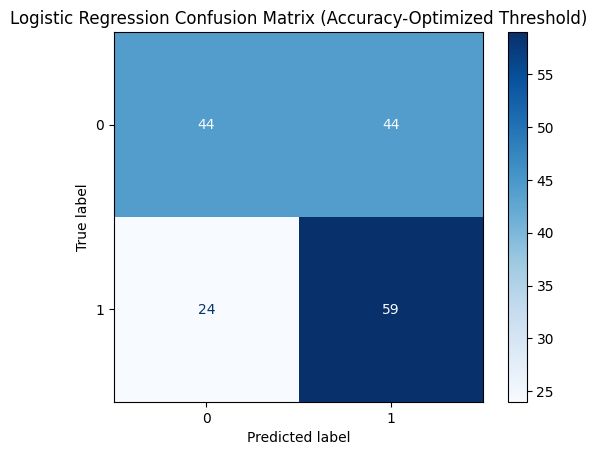

In [7]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    features, target_binary, test_size=0.2, random_state=42
)

# 2. Resample training data (SMOTE + undersampling)
resample = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('under', RandomUnderSampler(random_state=42))
])
X_train_res, y_train_res = resample.fit_resample(X_train, y_train)

# 3. Hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'class_weight': ['balanced']
}

grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=0
)
grid.fit(X_train_res, y_train_res)
clf = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# 4. Predict probabilities
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# 5. Precision-recall curve and best F1 threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
ap = average_precision_score(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_f1_idx = f1_scores.argmax()
best_f1_threshold = thresholds[best_f1_idx]
print(f"Best threshold for F1: {best_f1_threshold:.2f}, F1: {f1_scores[best_f1_idx]:.2f}")

# Find threshold that maximizes accuracy
acc_scores = [accuracy_score(y_test, (y_pred_proba > t).astype(int)) for t in thresholds]
best_acc_idx = int(np.argmax(acc_scores))
best_acc_threshold = thresholds[best_acc_idx]
print(f"Best threshold for Accuracy: {best_acc_threshold:.2f}, Accuracy: {acc_scores[best_acc_idx]:.2f}")

""" plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP={ap:.2f})')
plt.grid(True)
plt.show() """

# 6. Final predictions using best accuracy threshold
y_pred = (y_pred_proba > best_acc_threshold).astype(int)

# 7. Evaluation
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Binary Classification Accuracy (maximized): {accuracy:.2f}")
print(f"Binary Classification F1 Score (at accuracy threshold): {f1:.2f}")

# 8. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Logistic Regression Confusion Matrix (Accuracy-Optimized Threshold)")
plt.show()

# Logistic Regression Migraine Prediction

This notebook demonstrates migraine prediction using a Logistic Regression model. The workflow follows the structure of the Random Forest notebook, focusing on binary classification (migraine vs. no migraine) and addressing class imbalance.